In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time

In [47]:
df = pd.read_csv("../data/MSFT_with_vader_sentiment.csv", parse_dates = True, index_col = 'Date')
del df['Unnamed: 0']
del df['Unnamed: 0.1']
df

,Open,High,Low,Close,Adj Close,Volume,pos_vader,neg_vader,neu_vader,comp_vader
Date,,,,,,,,,,
2009-09-21,25.110001,25.370001,25.100000,25.299999,19.717058,28878700,0.0000,0.00000,1.0000,0.000000
2009-09-22,25.400000,25.820000,25.290001,25.770000,20.083347,61376700,0.2780,0.00000,0.7220,0.401900
2009-09-23,25.920000,26.250000,25.639999,25.709999,20.036585,60599900,0.2780,0.00000,0.7220,0.401900
2009-09-24,25.920000,26.110001,25.660000,25.940001,20.215834,56302900,0.1018,0.03440,0.8638,0.116600
2009-09-25,25.690001,25.820000,25.520000,25.549999,19.911896,50158900,0.2170,0.00000,0.7830,0.361200
...,...,...,...,...,...,...,...,...,...,...
2020-05-24,183.190002,184.460007,182.539993,183.509995,183.509995,20826900,0.1695,0.05925,0.7710,0.242000
2020-05-25,183.190002,184.460007,182.539993,183.509995,183.509995,20826900,0.1695,0.05925,0.7710,0.242000
2020-05-26,186.339996,186.500000,181.100006,181.570007,181.570007,36073600,0.1180,0.00000,0.8820,0.250000


In [48]:
# df.drop(columns=['Volume','Adj Close','pos_vader','neg_vader','neu_vader'],inplace=True)
df.drop(columns=['Volume','Adj Close','comp_vader'],inplace=True)

In [49]:
df.columns = [['open', 'high', 'low','close','pos','neg','neu']]

In [50]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [51]:
data = sc.fit_transform(df)

In [52]:
train_ind = int(0.6*len(df))
val_ind = train_ind + int(0.2*len(df))
train = data[:train_ind]
val = data[train_ind:val_ind]
test = data[val_ind:]

In [53]:
xtrain,ytrain,xval,yval,xtest,ytest = train[:,:],train[:,3],val[:,:],val[:,3],test[:,:],test[:,3]
xtrain.shape, ytrain.shape, 

((2341, 7), (2341,))

In [54]:
lookback = 60
n_features = 7
train_len = len(xtrain) - lookback
test_len = len(xtest) - lookback
val_len = len(xval) - lookback

In [55]:
x_train = np.zeros((train_len, lookback, n_features))
y_train = np.zeros((train_len))
for i in range(train_len):
    ytemp = i+lookback
    x_train[i] = xtrain[i:ytemp]
    y_train[i] = ytrain[ytemp]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_train (2281, 60, 7)
y_train (2281,)


In [56]:
x_val = np.zeros((val_len, lookback, n_features))
y_val = np.zeros((val_len))
for i in range(val_len):
    ytemp = i+lookback
    x_val[i] = xval[i:ytemp]
    y_val[i] = yval[ytemp]
print("x_val", x_val.shape)
print("y_val", y_val.shape)


x_val (720, 60, 7)
y_val (720,)


In [57]:
x_test = np.zeros((test_len, lookback, n_features))
y_test = np.zeros((test_len))
for i in range(test_len):
    ytemp = i+lookback
    x_test[i] = xtest[i:ytemp]
    y_test[i] = ytest[ytemp]
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_test (722, 60, 7)
y_test (722,)


In [58]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from time import time
from keras.callbacks import EarlyStopping

In [106]:
model = Sequential() 
model.add(LSTM(110,input_shape = (lookback, n_features), return_sequences=True))
model.add(LSTM(110))
model.add(Dense(1))

In [107]:
model.compile(loss = 'mse', optimizer = 'adam')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

In [108]:
start = time()
print("start:",0)
model.fit(x_train,y_train, epochs = 60, batch_size=40, 
          validation_data=(x_val,y_val),verbose = 1, 
          shuffle = False, callbacks=[earlystop])
print("end:",time()-start)

start: 0
Train on 2281 samples, validate on 720 samples
Epoch 1/60
2281/2281 [==============================] - 5s 2ms/step - loss: 0.0015 - val_loss: 0.0066
Epoch 2/60
2281/2281 [==============================] - 4s 2ms/step - loss: 0.0016 - val_loss: 0.0081
Epoch 3/60
2281/2281 [==============================] - 4s 2ms/step - loss: 0.0016 - val_loss: 0.0130
Epoch 4/60
2281/2281 [==============================] - 4s 2ms/step - loss: 0.0010 - val_loss: 0.0066
Epoch 5/60
2281/2281 [==============================] - 4s 2ms/step - loss: 8.8305e-04 - val_loss: 0.0081
Epoch 6/60
2281/2281 [==============================] - 4s 2ms/step - loss: 8.2586e-04 - val_loss: 0.0056
Epoch 7/60
2281/2281 [==============================] - 4s 2ms/step - loss: 6.1795e-04 - val_loss: 0.0023
Epoch 8/60
2281/2281 [==============================] - 4s 2ms/step - loss: 3.6667e-04 - val_loss: 5.4973e-04
Epoch 9/60
2281/2281 [==============================] - 4s 2ms/step - loss: 2.0997e-04 - val_loss: 2.1563e-0

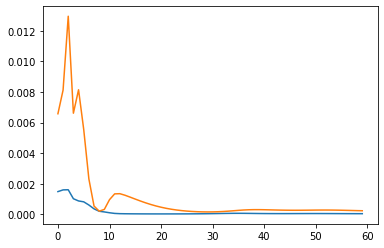

In [109]:
loss = model.history.history
loss = pd.DataFrame(loss)
loss.to_csv("losses/model1.csv")
plt.plot(loss['loss'])
plt.plot(loss['val_loss'])
plt.savefig("losses/model1.png")

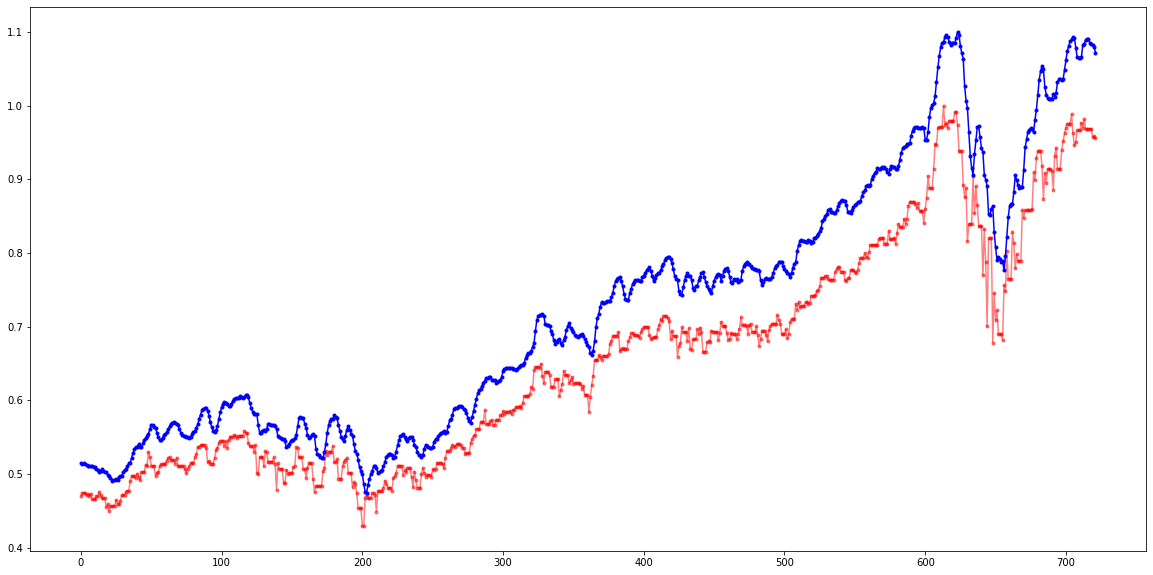

In [110]:
y_pred = model.predict(x_test)

plt.figure(figsize=(20,10))
plt.plot( y_test, '.-', color='red', label='Real values', alpha=0.5)
plt.plot( y_pred, '.-', color='blue', label='Predicted values', alpha=1)
plt.savefig("pred_model1.png")

In [71]:
model.save("stock_sentiment_vader1.h5")

In [65]:
model.evaluate(x_test, y_test)

722/722 [==============================] - 0s 543us/step


0.0015873273078692751

In [53]:
model1 = load_model("stock_sentiment_1.h5")
model11 = load_model("stock_sentiment_11.h5")

In [50]:
model1.evaluate(x_test,y_test)

722/722 [==============================] - 0s 547us/step


0.0014917453431067705

In [51]:
results_original = pd.read_csv("../stock_prediction/without_sentiment.csv")

In [52]:
results_original

,Unnamed: 0,0
0,0,0.000373
1,1,0.005508
2,2,0.001133
3,3,0.009937
4,4,0.004588
5,5,0.000835
6,6,0.013204
7,7,0.000327
8,8,0.005302
9,9,0.000360


In [54]:
model11.evaluate(x_test,y_test)

722/722 [==============================] - 0s 565us/step


0.0007189869612372813